In [1]:
# code to replicate arXiv:1412.2043v2
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
# all units should be natural units and in GeV

In [30]:
M_pl = 2.435e18 # [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
g_star = 427/4 # during reheating from paper
sigma_eff = 1e-31 # [GeV^-2] from paper heavy neutrino exchange 
N_f = 3 # [1] fermion generations
# TODO: renormalization group running?
g_2 = 0.652 # [1] from wikipedia (https://en.wikipedia.org/wiki/Mathematical_formulation_of_the_Standard_Model#Free_parameters)
alpha = g_2**2 / (4 * np.pi) # eq. from paper
theta0 = 1 # use value from paper for now (maybe vary it later?)
H_inf_max = 2e10 # from fig. 1
c_shaleron = 28/79 # from paper
g_star_0 = 43/11 # from paper
eta_B_observed = 6e-10 # from paper
L_to_B_final_factor = c_shaleron * g_star_0 / g_star
def eta_L_a_to_eta_B_0(eta_L_a): return L_to_B_final_factor * eta_L_a

In [39]:
def rhs(log_t, log_y, m_a, f_a, Gamma_phi):
    y = np.exp(log_y)
    t = np.exp(log_t)
    # friedmann
    a, d_a_d_log_t, n_L, rho_phi, rho_R = y
    
    rho_total = rho_phi + rho_R
    H = np.sqrt(rho_total) / (np.sqrt(3) * M_pl)
    T = (np.pi**2 / 3 * g_star * rho_R)**(1/4)
    # axion eom
    axion_pot_deriv = m_a**2 * a
    a_dot2 = - 3 * H * a - axion_pot_deriv
    # boltzmann eq. for lepton asymmetry
    mu_eff = a_dot / f_a
    n_L_eq = 4 / np.pi**2 * mu_eff * T**2
    n_l_eq = 2 / np.pi**2 * T**3
    Gamma_L = 4 * n_l_eq * sigma_eff
    n_L_dot = - 3 * H * n_L - Gamma_L * (n_L - n_L_eq)
    # reheating energy equations
    rho_phi_dot = - 3 * H * rho_phi - Gamma_phi * rho_phi
    rho_R_dot   = - 4 * H * rho_R   + Gamma_phi * rho_phi
    # final result
    y_dot = [a_dot, a_dot2, n_L_dot, rho_phi_dot, rho_R_dot]
    return y_dot

In [3]:
def calc_Gamma_a(m_a, f_a):
    return alpha**2 / (64 * np.pi**3) * m_a**3 / f_a**2
def calc_a0(f_a):
    return theta0 * f_a

In [41]:
def solve_eom():
    # slow roll condition???
    # TODO: how do I get rho_phi(t0)???
    rho_phi0 = 1.0
    a0 = calc_a0(f_a)
    initial_cond = [a0, 0.0, 0.0, rho_phi0, 0.0]
    # TODO: how do I get t0?????
    t0 = 1.0
    Gamma_a = calc_Gamma_a(m_a, f_a)
    t_axion_decay = 1 / Gamma_a
    tmax = 10 # t_axion_decay
    m_a = 1e8 # [GeV]
    f_a = 3e14 # [GeV] from fig. 1
    Gamma_phi = 1e8 # [GeV]
    sol = solve_ivp(rhs, (t0, tmax), initial_cond, args=(m_a, f_a, Gamma_phi), t_eval=np.linspace(t0, tmax, 500))

<ipython-input-39-da263a60f160>:2: RuntimeWarning: overflow encountered in exp
  y = np.exp(log_y)


NameError: name 'a_dot' is not defined

In [10]:
def calc_Delta_a(m_a, f_a, Gamma_phi):
    a0 = calc_a0(f_a)
    Delta_a_prime = 2*np.pi**2 / alpha * f_a * a0**2 / (m_a * M_pl**2) * min((1, (Gamma_phi / m_a)**0.5))
    Delta_a = max((1, Delta_a_prime))
    return Delta_a

def calc_eta_L_a_analytic(m_a, f_a, Gamma_phi):
    Gamma_a = calc_Gamma_a(m_a, f_a)
    a0 = calc_a0(f_a)
    eta_L_max = sigma_eff * a0 / (g_star**0.5 * f_a) * m_a * M_pl * min((1, (Gamma_phi / m_a)**0.5))
    Delta_phi_prime = (m_a / Gamma_phi)**(5 / 4)
    Delta_phi = max((1, Delta_phi_prime))
    Delta_a = calc_Delta_a(m_a, f_a, Gamma_phi)
    T_RH = 2e13*(Gamma_phi / 1e9)**0.5
    T_L = g_star**0.5 / (np.pi * M_pl * sigma_eff)
    kappa = np.where(m_a > Gamma_phi, T_RH / T_L, 0)
    C = np.where(m_a > Gamma_phi, 2.2, 1.5) # factor determined in paper
    eta_L_a = C * Delta_a**-1 * Delta_phi**-1 * eta_L_max * np.exp(-kappa)
    return eta_L_a

In [11]:
f_a_list = [1e12, 1e12, 1e15, 1e15]
m_a_list = [3e7, 3e6, 1e10, 1e9]
Gamma_phi_list = [3e6, 3e7, 1e9, 1e10]
def print_table():
    print("f_a, m_a, Gamma_phi, eta_L^a, Delta_a")
    for f_a, m_a, Gamma_phi in zip(f_a_list, m_a_list, Gamma_phi_list):
        print(f"{f_a:e}, {m_a:e}, {Gamma_phi:e}, {eta_L_a_to_eta_B_0(calc_eta_L_a_analytic(m_a, f_a, Gamma_phi)):e}, {calc_Delta_a(m_a, f_a, Gamma_phi):e}")
print_table() # 

f_a, m_a, Gamma_phi, eta_L^a, Delta_a
1.000000e+12, 3.000000e+07, 3.000000e+06, 3.315723e-10, 1.000000e+00
1.000000e+12, 3.000000e+06, 3.000000e+07, 1.378704e-09, 1.000000e+00
1.000000e+15, 1.000000e+10, 1.000000e+09, 8.760594e-09, 3.112049e+00
1.000000e+15, 1.000000e+09, 1.000000e+10, 4.669852e-09, 9.841164e+01


Text(0.5, 1.0, 'Analytic Expression for the Baryon Asymmetry')

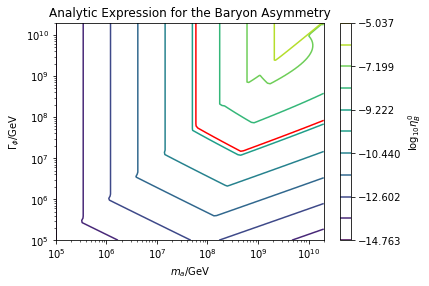

In [52]:
# make a plot of the final baryon asymmetry as a function of the axion mass and the inflaton
# decay rate and highlight the contourline with the observed asymmetry
steps = 100
f_a = 3e14
Gamma_phis = np.geomspace(1e5, H_inf_max, steps) # constraint
m_as = np.geomspace(1e5, H_inf_max, steps + 1) # constraint
eta_B_0 = np.array([[eta_L_a_to_eta_B_0(calc_eta_L_a_analytic(m_a, f_a, Gamma_phi)) 
            for m_a in m_as] for Gamma_phi in Gamma_phis])
log_eta = np.log10(eta_B_0)
levels = np.sort(np.concatenate([np.linspace(np.min(log_eta), np.max(log_eta), 10), [np.log10(eta_B_observed)]]))
CS = plt.contour(m_as, Gamma_phis, log_eta, levels=levels)
cbar = plt.colorbar()
cbar.set_label(r"$\log_{10} \eta_B^0$")
line = CS.collections[np.where(CS.levels == np.log10(eta_B_observed))[0][0]]
line.set_color("red")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$m_a / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
plt.title("Analytic Expression for the Baryon Asymmetry")